In [61]:
import numpy as np
import pandas as pd
import librosa 
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import tensorflow as tf

In [62]:
BASE_PATH = '../input/asvpoof-2019-dataset/LA/LA'

In [63]:
FOLDS = 10
SEED = 101
DEBUG = True

# Audio params
SAMPLE_RATE = 16000
DURATION = 5.0 # duration in second
AUDIO_LEN = int(SAMPLE_RATE * DURATION)

# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 # time axis
HOP_LEN = AUDIO_LEN//(SPEC_WIDTH - 1) # non-overlap region
FMAX = SAMPLE_RATE//2 # max frequency
SPEC_SHAPE = [SPEC_WIDTH, N_MELS] # output spectrogram shape

In [64]:
train_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt',
                       sep=" ", header=None)

In [65]:
train_df.head(5)

,0,1,2,3,4
0,LA_0079,LA_T_1138215,-,-,bonafide
1,LA_0079,LA_T_1271820,-,-,bonafide
2,LA_0079,LA_T_1272637,-,-,bonafide
3,LA_0079,LA_T_1276960,-,-,bonafide
4,LA_0079,LA_T_1341447,-,-,bonafide


In [66]:
train_df.tail(5)

,0,1,2,3,4
25375,LA_0098,LA_T_9717580,-,A06,spoof
25376,LA_0098,LA_T_9779814,-,A06,spoof
25377,LA_0098,LA_T_9783312,-,A06,spoof
25378,LA_0098,LA_T_9839348,-,A06,spoof
25379,LA_0098,LA_T_9982036,-,A06,spoof


In [67]:
train_df.columns =['speaker_id','filename','system_id','null','class_name']
train_df.drop(columns=['null'],inplace=True)
train_df.head(5)

,speaker_id,filename,system_id,class_name
0,LA_0079,LA_T_1138215,-,bonafide
1,LA_0079,LA_T_1271820,-,bonafide
2,LA_0079,LA_T_1272637,-,bonafide
3,LA_0079,LA_T_1276960,-,bonafide
4,LA_0079,LA_T_1341447,-,bonafide


In [68]:
train_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_train/flac/'+train_df.filename+'.flac'
train_df['target'] = (train_df.class_name=='spoof').astype('int32')
# train_df = train_df.groupby(['target']).sample(2500).reset_index(drop=True)
print('len Train', len(train_df))
train_df.head(5)

len Train 25380


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0079,LA_T_1138215,-,bonafide,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,0
1,LA_0079,LA_T_1271820,-,bonafide,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,0
2,LA_0079,LA_T_1272637,-,bonafide,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,0
3,LA_0079,LA_T_1276960,-,bonafide,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,0
4,LA_0079,LA_T_1341447,-,bonafide,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,0


In [69]:
train_df['filepath'][1]

'../input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac/LA_T_1271820.flac'

In [70]:
train_df['target'].value_counts()

target
1    22800
0     2580
Name: count, dtype: int64

In [71]:
neg, pos = np.bincount(train_df['target'])
print(f'positive count:{pos} negative count:{neg}')
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


pos_wt = train_df.shape[0]/(2*pos)
neg_wt = train_df.shape[0]/(2*neg)
class_weight = {1:pos_wt,0:neg_wt}
print(class_weight)

positive count:22800 negative count:2580
Examples:
    Total: 25380
    Positive: 22800 (89.83% of total)

{1: 0.5565789473684211, 0: 4.9186046511627906}


In [72]:
eval_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt',
                       sep=" ", header=None)

In [73]:
eval_df.head(2)

,0,1,2,3,4
0,LA_0069,LA_D_1047731,-,-,bonafide
1,LA_0069,LA_D_1105538,-,-,bonafide


In [74]:
eval_df.columns =['speaker_id','filename','system_id','null','class_name']
eval_df.drop(columns=['null'],inplace=True)
eval_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_dev/flac/'+eval_df.filename+'.flac'
eval_df['target'] = (eval_df.class_name=='spoof').astype('int32')
# eval_df = eval_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Len Eval: {len(eval_df)}')
eval_df.head(2)

Len Eval: 24844


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0069,LA_D_1047731,-,bonafide,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,0
1,LA_0069,LA_D_1105538,-,bonafide,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,0


In [75]:
test_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt',
                       sep=" ", header=None)
test_df.columns =['speaker_id','filename','system_id','null','class_name']
test_df.drop(columns=['null'],inplace=True)
test_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_eval/flac/'+test_df.filename+'.flac'
test_df['target'] = (test_df.class_name=='spoof').astype('int32')
# test_df = test_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Len Test: {len(test_df)}')
test_df.head(2)

Len Test: 71237


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0039,LA_E_2834763,-,spoof,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,1
1,LA_0014,LA_E_8877452,-,spoof,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,1


In [76]:
def load_audio(filepath, sr=16000):
    audio, sr = librosa.load(filepath, sr=sr)
    return audio, sr

def plot_audio(audio, sr=16000):
    fig = librosa.display.waveshow(audio, axis='time', sr=sr)
    return fig

def listen_audio(audio, sr=16000):
    display(ipd.Audio(audio, rate=sr))
    
def get_spec(audio):
    spec = librosa.feature.melspectrogram(y=audio, fmax=FMAX, n_mels=N_MELS, hop_length=HOP_LEN, n_fft=N_FFT)
    spec = librosa.power_to_db(spec)
    return spec

def plot_spec(spec, sr=16000):
    fig = librosa.display.specshow(spec, x_axis='time', y_axis='hz', hop_length=HOP_LEN, sr=SAMPLE_RATE, fmax=FMAX,)
    return fig

> Filename: LA_T_4179989 | Label: bonafide
# Listen


# Plot



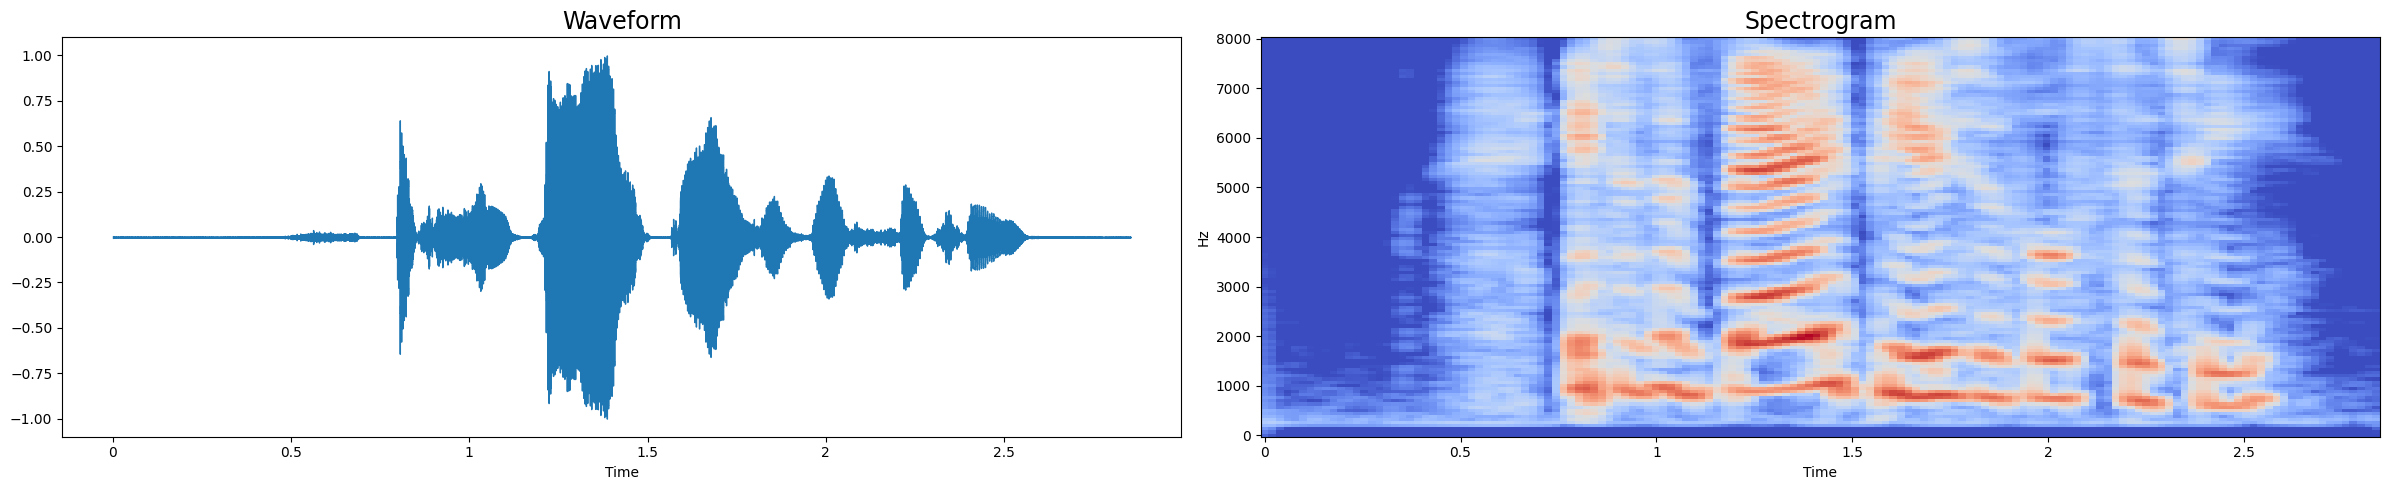

In [77]:
row = train_df[train_df.target==0].iloc[50]
print(f'> Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
audio = audio[:AUDIO_LEN]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
plt.figure(figsize=(12*2,5))

plt.subplot(121)
plot_audio(audio)
plt.title("Waveform",fontsize=17)

plt.subplot(122)
plot_spec(spec);
plt.title("Spectrogram",fontsize=17)

plt.tight_layout()
plt.show()

In [78]:
spec.shape

(128, 146)

In [ ]:
row = train_df[train_df.target==1].iloc[50]
print(f'> Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
audio = audio[:AUDIO_LEN]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
plt.figure(figsize=(12*2,5))

plt.subplot(121)
plot_audio(audio)
plt.title("Waveform",fontsize=17)

plt.subplot(122)
plot_spec(spec)
plt.title("Spectrogram",fontsize=17)

plt.tight_layout()
plt.show()

In [79]:
import random
import logging

from tensorflow import keras
from tensorflow.keras import layers

In [83]:
train_audio_files = train_df['filepath'].values
train_label = train_df['target'].valwues.reshape(-1,1)

In [84]:
train_audio_ds = tf.data.Dataset.from_tensor_slices(train_audio_files)
train_label_ds = tf.data.Dataset.from_tensor_slices(train_label)

In [85]:
def tokenizer(x):
    data,sr = librosa.load(x.numpy().decode('utf-8'), sr=SAMPLE_RATE)
    inputs = feature_extractor(
        data,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=MAX_SEQ_LENGTH,
        truncation=True,
        padding="max_length"
    )
    return { "input_ids": inputs['input_values'], "attention_mask": inputs['attention_mask']}

def py_func(x):
  d = tokenizer(x)
  return list(d.values())

def ds_map_fn(x):
  flattened_output = tf.py_function(py_func, [x], [tf.float32, tf.int32])
  return {"input_values": flattened_output[0][0], "attention_mask": flattened_output[1][0]}

In [86]:
train_ds = train_audio_ds.map(ds_map_fn)

In [87]:
next(iter(train_ds))

{'input_values': <tf.Tensor: shape=(16000,), dtype=float32, numpy=
 array([0.02054626, 0.02089404, 0.01915514, ..., 3.550506  , 2.5892444 ,
        1.2624662 ], dtype=float32)>,
 'attention_mask': <tf.Tensor: shape=(16000,), dtype=int32, numpy=array([1, 1, 1, ..., 1, 1, 1], dtype=int32)>}

In [88]:
train_ds = tf.data.Dataset.zip((train_ds,train_label_ds))

In [89]:
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size=1024)
train_ds = train_ds.batch(8,drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [90]:
eval_audio_files = eval_df['filepath'].values
eval_label = eval_df['target'].values.reshape(-1,1)

In [91]:
eval_audio_ds = tf.data.Dataset.from_tensor_slices(eval_audio_files)
eval_label_ds = tf.data.Dataset.from_tensor_slices(eval_label)

In [92]:
eval_ds = eval_audio_ds.map(ds_map_fn)

In [93]:
next(iter(eval_ds))

{'input_values': <tf.Tensor: shape=(16000,), dtype=float32, numpy=
 array([ 0.538901  ,  0.568998  ,  0.7495803 , ...,  1.5922979 ,
         0.96025974, -0.30381662], dtype=float32)>,
 'attention_mask': <tf.Tensor: shape=(16000,), dtype=int32, numpy=array([1, 1, 1, ..., 1, 1, 1], dtype=int32)>}

In [94]:
eval_ds = eval_ds.batch(8,drop_remainder=True)

In [95]:
test_audio_files = test_df['filepath'].values
test_label = test_df['target'].values.reshape(-1,1)

In [96]:
test_audio_ds = tf.data.Dataset.from_tensor_slices(test_audio_files)
test_label_ds = tf.data.Dataset.from_tensor_slices(test_label)

In [97]:
test_ds = test_audio_ds.map(ds_map_fn)
test_ds = tf.data.Dataset.zip((test_ds,test_label_ds))

In [98]:
test_ds = test_ds.batch(8,drop_remainder=True)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [99]:
from transformers import TFWav2Vec2Model


def mean_pool(hidden_states, feature_lengths):
    attenion_mask = tf.sequence_mask(
        feature_lengths, maxlen=MAX_FRAMES, dtype=tf.dtypes.int64
    )
    padding_mask = tf.cast(
        tf.reverse(tf.cumsum(tf.reverse(attenion_mask, [-1]), -1), [-1]),
        dtype=tf.dtypes.bool,
    )
    hidden_states = tf.where(
        tf.broadcast_to(
            tf.expand_dims(~padding_mask, -1), (BATCH_SIZE, MAX_FRAMES, HIDDEN_DIM)
        ),
        0.0,
        hidden_states,
    )
    pooled_state = tf.math.reduce_sum(hidden_states, axis=1) / tf.reshape(
        tf.math.reduce_sum(tf.cast(padding_mask, dtype=tf.dtypes.float32), axis=1),
        [-1, 1],
    )
    return pooled_state


class TFWav2Vec2ForAudioClassification(layers.Layer):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, model_checkpoint, num_classes):
        super().__init__()
        # Instantiate the Wav2Vec 2.0 model without the Classification-Head
        self.wav2vec2 = TFWav2Vec2Model.from_pretrained(
            model_checkpoint, apply_spec_augment=False, from_pt=True
        )
        self.pooling = layers.GlobalAveragePooling1D()
        # Drop-out layer before the final Classification-Head
        self.intermediate_layer_dropout = layers.Dropout(0.5)
        # Classification-Head
        self.final_layer = layers.Dense(num_classes, activation="sigmoid")

    def call(self, inputs):
        # We take only the first output in the returned dictionary corresponding to the
        # output of the last layer of Wav2vec 2.0
        hidden_states = self.wav2vec2(inputs["input_values"])[0]

        # If attention mask does exist then mean-pool only un-masked output frames
        if tf.is_tensor(inputs["attention_mask"]):
            # Get the length of each audio input by summing up the attention_mask
            # (attention_mask = (BATCH_SIZE x MAX_SEQ_LENGTH) ∈ {1,0})
            audio_lengths = tf.cumsum(inputs["attention_mask"], -1)[:, -1]
            # Get the number of Wav2Vec 2.0 output frames for each corresponding audio input
            # length
            feature_lengths = self.wav2vec2.wav2vec2._get_feat_extract_output_lengths(
                audio_lengths
            )
            pooled_state = mean_pool(hidden_states, feature_lengths)
        # If attention mask does not exist then mean-pool only all output frames
        else:
            pooled_state = self.pooling(hidden_states)

        intermediate_state = self.intermediate_layer_dropout(pooled_state)
        final_state = self.final_layer(intermediate_state)

        return final_state

In [100]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [101]:
def build_model():
    # Model's input
    inputs = {
        "input_values": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="float32"),
        "attention_mask": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="int32"),
    }
    # Instantiate the Wav2Vec 2.0 model with Classification-Head using the desired
    # pre-trained checkpoint
    wav2vec2_model = TFWav2Vec2ForAudioClassification(MODEL_CHECKPOINT, NUM_CLASSES)(
        inputs
    )
    # Model
    model = tf.keras.Model(inputs, wav2vec2_model)
    # Loss
    loss = tf.keras.losses.binary_crossentropy
    # Optimizer
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    # Compile and return
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


with tf.device(device_name):
    model = build_model()
    
# with tpu_strategy.scope():
#     model = build_model()


TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFWav2Vec2Model: ['quantizer.weight_proj.bias', 'project_hid.weight', 'quantizer.weight_proj.weight', 'project_q.weight', 'project_q.bias', 'quantizer.codevectors', 'project_hid.bias']
- This IS expected if you are initializing TFWav2Vec2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFWav2Vec2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFWav2Vec2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the che